In [ ]:
# Copyright 2022 Google LLC

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import dataclasses
import os
import tensorflow.compat.v1 as tf
import itertools
import json
import sys
import numpy as np
import pandas as pd

2024-11-11 15:02:39.645984: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 15:02:39.816369: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 15:02:39.875815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 15:02:39.963811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 15:02:39.981802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 15:02:40.086313: I tensorflow/core/platform/cpu_feature_gu

In [2]:
if 'gfile' not in sys.modules:
  gfile = tf.io.gfile

In [3]:
gfile

<module 'tensorflow._api.v2.compat.v1.io.gfile' from '/work/radlab/Ayan/envs/tlp/lib/python3.12/site-packages/tensorflow/_api/v2/compat/v1/io/gfile/__init__.py'>

In [4]:
PROJECT_ROOT = '/work/radlab/Ayan/tlp/google-research/fm4tlp'
SUBDIR = 'readme_experiment'

In [8]:
MODELS = [
    'tgn',
    'edgebank',
    'tgn_structmap'
]
DATA = [
    #'tgbl_wiki;cc-subgraph;cc-subgraph;cc-subgraph',
    #'tgbl_coin;cc-subgraph;cc-subgraph;cc-subgraph',
    #'tgbl_review;cc-subgraph;cc-subgraph;cc-subgraph',
    #'tgbl_comment;cc-subgraph;cc-subgraph',
    'tgbl_flight;AS;AS;AF', #works
    #'tgbl_flight;AS;AS;SA', #doesn't
    #'tgbl_flight;AS;AS;OC', #doesn't
    #'tgbl_flight;OC;OC;AS', #works well
    #'tgbl_flight;OC;OC;AF', #works
    #'tgbl_flight;OC;OC;SA', #works
    #'tgbl_flight;SA;SA;AF', #doesn't
    #'tgbl_flight;SA;SA;AS', #doesn't
    #'tgbl_flight;SA;SA;OC', #no
    #'tgbl_flight;AF;AF;SA', #no
    #'tgbl_flight;AF;AF;OC', #no
    #'tgbl_flight;AF;AF;AS', #no
]
EXPERIMENTS = [
    'transductive',
    'transfer_no_warmstart',
    'transfer_warmstart',
]
MODELS_EXPERIMENTS = ['tgn-transfer_no_warmstart','tgn-transfer_warmstart','tgn_structmap-transfer_no_warmstart']

In [9]:
# Transform inputs.
@dataclasses.dataclass(frozen=False)
class DatasetSpec:
  dataset: str = dataclasses.field(default_factory=str)
  train_split: str = dataclasses.field(default_factory=str)
  val_split: str = dataclasses.field(default_factory=str)
  test_split: str = dataclasses.field(default_factory=str)

@dataclasses.dataclass(frozen=False)
class ExperimentResults:
  experiment: str = dataclasses.field(default_factory=str)
  train_results: dict[str, float] = dataclasses.field(default_factory=dict)
  test_results: dict[str, float] = dataclasses.field(default_factory=dict)
  val_warmstart_loss_metrics: pd.DataFrame = dataclasses.field(default_factory=pd.DataFrame)
  val_loss_metrics: pd.DataFrame = dataclasses.field(default_factory=pd.DataFrame)
  test_warmstart_loss_metrics: pd.DataFrame = dataclasses.field(default_factory=pd.DataFrame)
  test_loss_metrics: pd.DataFrame = dataclasses.field(default_factory=pd.DataFrame)

@dataclasses.dataclass(frozen=False)
class ModelResults:
  model: str = dataclasses.field(default_factory=str)
  experiment_results: dict[str, ExperimentResults] = dataclasses.field(default_factory=dict)

@dataclasses.dataclass(frozen=False)
class DatasetResults:
  dataset: str = dataclasses.field(default_factory=str)
  model_results: dict[str, ModelResults] = dataclasses.field(default_factory=dict)

DATASET_SPECS = []
DATASETS = []
for dataset_string in DATA:
  dataset, train_split, val_split, test_split = dataset_string.split(';')
  DATASETS.append(dataset)
  DATASET_SPECS.append(DatasetSpec(dataset, train_split, val_split, test_split))

RESULTS_SUBDIR = os.path.join(PROJECT_ROOT, 'experiments', SUBDIR)

In [10]:
ALL_RESULTS = {}
train_results_df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [MODELS, EXPERIMENTS],
        names=['Model', 'Experiment']
    ),
    columns=pd.MultiIndex.from_product(
        [DATASETS, ['auc', 'mrr']],
        names=['Dataset', 'Metric']
    )
)
test_results_df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [MODELS, EXPERIMENTS],
        names=['Model', 'Experiment']
    ),
    columns=pd.MultiIndex.from_product(
        [DATASETS, ['auc', 'mrr']],
        names=['Dataset', 'Metric']
    )
)
for dataset_spec in DATASET_SPECS:
  dataset_results = DatasetResults(dataset=dataset_spec.dataset)
  for model in MODELS:
    model_results = ModelResults(model=model)
    model_dataset_folder = os.path.join(
        RESULTS_SUBDIR,
        dataset_spec.dataset, 'results',
        f'{model}_{dataset_spec.dataset}_{dataset_spec.train_split}_{dataset_spec.val_split}'
    )
    for experiment in EXPERIMENTS:
      if str(model) + '-' + str(experiment) in MODELS_EXPERIMENTS:
          # Extract results for train.
          experiment_results = ExperimentResults(experiment=experiment)
          with gfile.GFile(os.path.join(model_dataset_folder, f'{experiment}_results_train.json'), 'r') as f:
            experiment_results.train_results = json.load(f)
          with gfile.GFile(os.path.join(model_dataset_folder, f'{experiment}_val_loss.csv'), 'r') as f:
            experiment_results.val_loss_metrics = pd.read_csv(f)
          if not 'no_warmstart' in experiment:
            with gfile.GFile(os.path.join(model_dataset_folder, f'{experiment}_val_loss.csv'), 'r') as f:
              experiment_results.val_warmstart_loss_metrics = pd.read_csv(f)
          train_results_df.loc[model, experiment].at[dataset_spec.dataset, 'auc'] = experiment_results.train_results['auc']
          train_results_df.loc[model, experiment].at[dataset_spec.dataset, 'mrr'] = experiment_results.train_results['val mrr']

          # Extract results for test.
          # TODO: save test_split-specific results in their own subfolder of the train/val split folder.
          with tf.io.gfile.GFile(os.path.join(model_dataset_folder, f'{experiment}_results_test_{dataset_spec.test_split}.json'), 'r') as f:
            experiment_results.test_results = json.load(f)
          with tf.io.gfile.GFile(os.path.join(model_dataset_folder, f'{experiment}_test_{dataset_spec.test_split}_loss.csv'), 'r') as f:
            experiment_results.test_loss_metrics = pd.read_csv(f)
          if not 'no_warmstart' in experiment:
            with tf.io.gfile.GFile(os.path.join(model_dataset_folder, f'{experiment}_test_{dataset_spec.test_split}_loss.csv'), 'r') as f:
              experiment_results.test_warmstart_loss_metrics = pd.read_csv(f)
          # TODO: align metric variable names across train and test.
          test_results_df.loc[model, experiment].at[dataset_spec.dataset, 'auc'] = experiment_results.test_results['test auc']
          test_results_df.loc[model, experiment].at[dataset_spec.dataset, 'mrr'] = experiment_results.test_results['test mrr']

          model_results.experiment_results[experiment] = experiment_results

    dataset_results.model_results[model] = model_results
  ALL_RESULTS[dataset_spec.dataset] = dataset_results

In [11]:
dataset_spec

DatasetSpec(dataset='tgbl_flight', train_split='AS', val_split='AS', test_split='AF')

In [12]:
import copy
import seaborn as sns
from matplotlib import pyplot as plt

def plot_eval_metric_curves(
    dataset='tgbl_wiki',
    experiments=EXPERIMENTS,
    models=['tgn','tgn_structmap'],
    model_experiemnts=MODELS_EXPERIMENTS,
    val=True,
    metric_name='perf',
    batches_plot=100,
    plot_warmstart_period=False,
    master_results_dict=ALL_RESULTS,
    dataset_spec=DATASET_SPECS):

  eval_df_string = 'val' if val else 'test'
  plot_dataframes = []

  # Make sure that if there is warmstart experiment that it comes first.
  experiment_list = copy.deepcopy(experiments)
  first_experiment = ''
  for experiment in experiment_list:
    if 'no_warmstart' not in experiment:
      first_experiment = copy.deepcopy(experiment)
  experiment_list.remove(first_experiment)
  experiment_list = [first_experiment] + experiment_list

  warmstart_end_index = 0
  for idx, experiment in enumerate(experiment_list):
    for model in models:
        if str(model) + '-' + str(experiment) in model_experiemnts:
            if ('no_warmstart' not in experiment) and plot_warmstart_period:
              warmstart_df = getattr(
                  master_results_dict[dataset].model_results[model].experiment_results[experiment],
                  f'{eval_df_string}_warmstart_loss_metrics'
              )
              if idx == 0:
                warmstart_end_index = len(warmstart_df)
              warmstart_df['batch_index'] = list(range(warmstart_end_index))
              warmstart_df = warmstart_df.melt(
                  id_vars=['batch_index'],
                  value_vars=['loss', 'perf', 'auc'],
                  value_name='metric_value',
                  var_name='metric_name'
              )
              warmstart_df['experiment'] = model + '-' + experiment
              warmstart_df = warmstart_df[warmstart_df.metric_name == metric_name]
              warmstart_df['period'] = 'warmstart'
              plot_dataframes.append(warmstart_df.head(batches_plot))

            eval_df = getattr(
                master_results_dict[dataset].model_results[model].experiment_results[experiment],
                f'{eval_df_string}_loss_metrics'
            )
            eval_df['batch_index'] = list(range(warmstart_end_index, len(eval_df) + warmstart_end_index))
            eval_df = eval_df.melt(
                id_vars=['batch_index'],
                value_vars=['loss', 'perf', 'auc'],
                value_name='metric_value',
                var_name='metric_name'
            )
            eval_df['experiment'] = model + '-' + experiment
            eval_df = eval_df[eval_df.metric_name == metric_name]
            eval_df['period'] = 'eval'
            plot_dataframes.append(eval_df.head(batches_plot))

  # Make plot.
  master_plot_dataframe = pd.concat(plot_dataframes, axis=0)
  plt.figure(figsize=(15, 10))
  plt.title(f'{dataset} {eval_df_string} {metric_name}')
  sns.lineplot(
      data=master_plot_dataframe,
      x='batch_index',
      y='metric_value',
      hue='experiment',
      style='period'
  )
  plt.show()
  return master_plot_dataframe

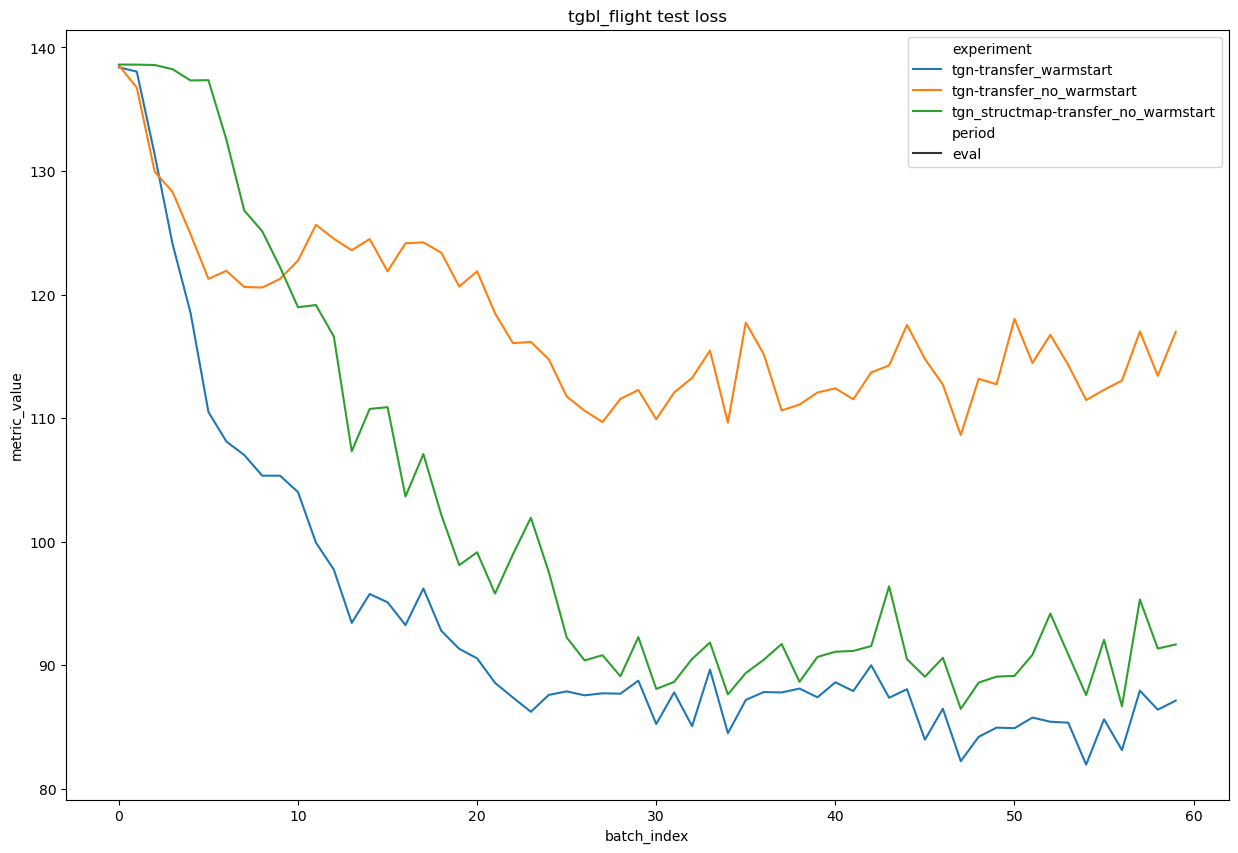

In [13]:
plot_df = plot_eval_metric_curves(dataset='tgbl_flight', metric_name='loss', batches_plot=60, val=False)

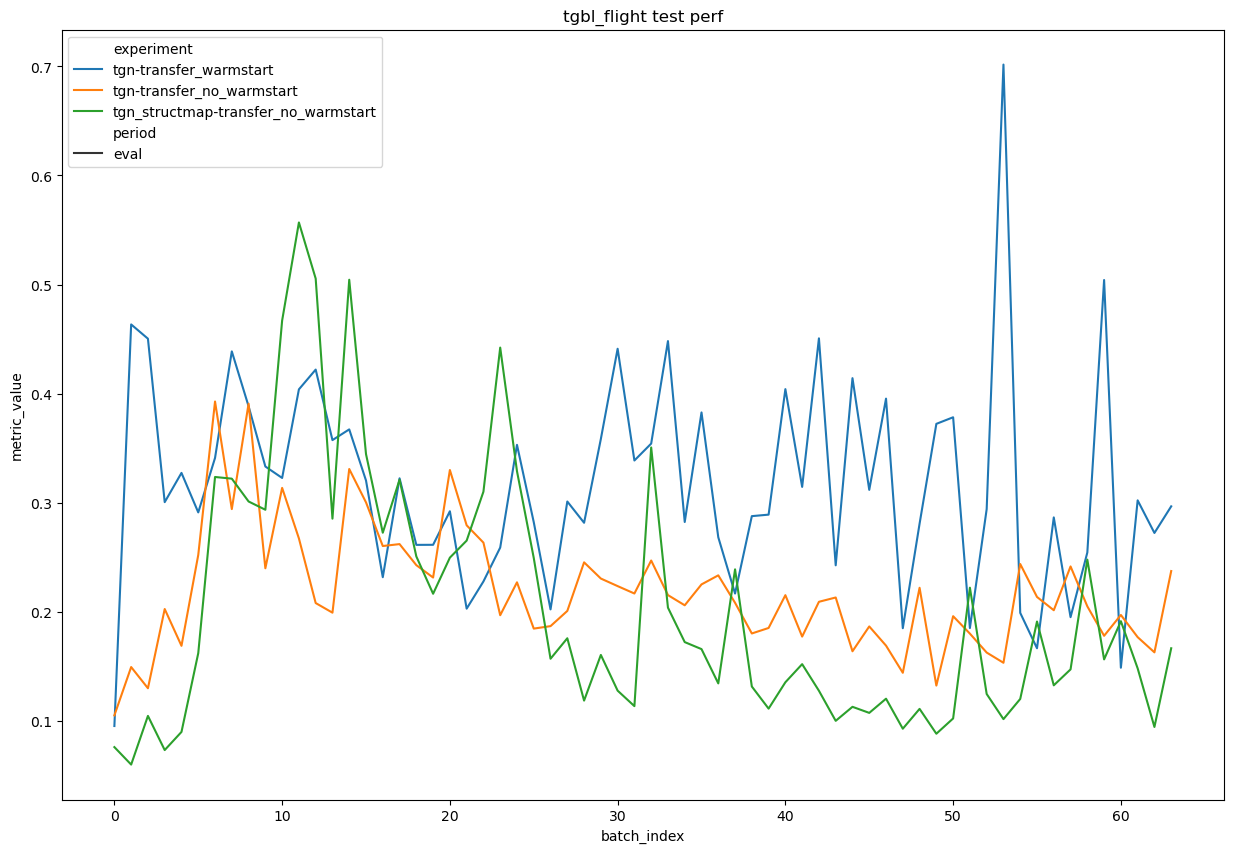

In [11]:
plot_df = plot_eval_metric_curves(dataset='tgbl_flight', metric_name='perf', batches_plot=100, val=False)

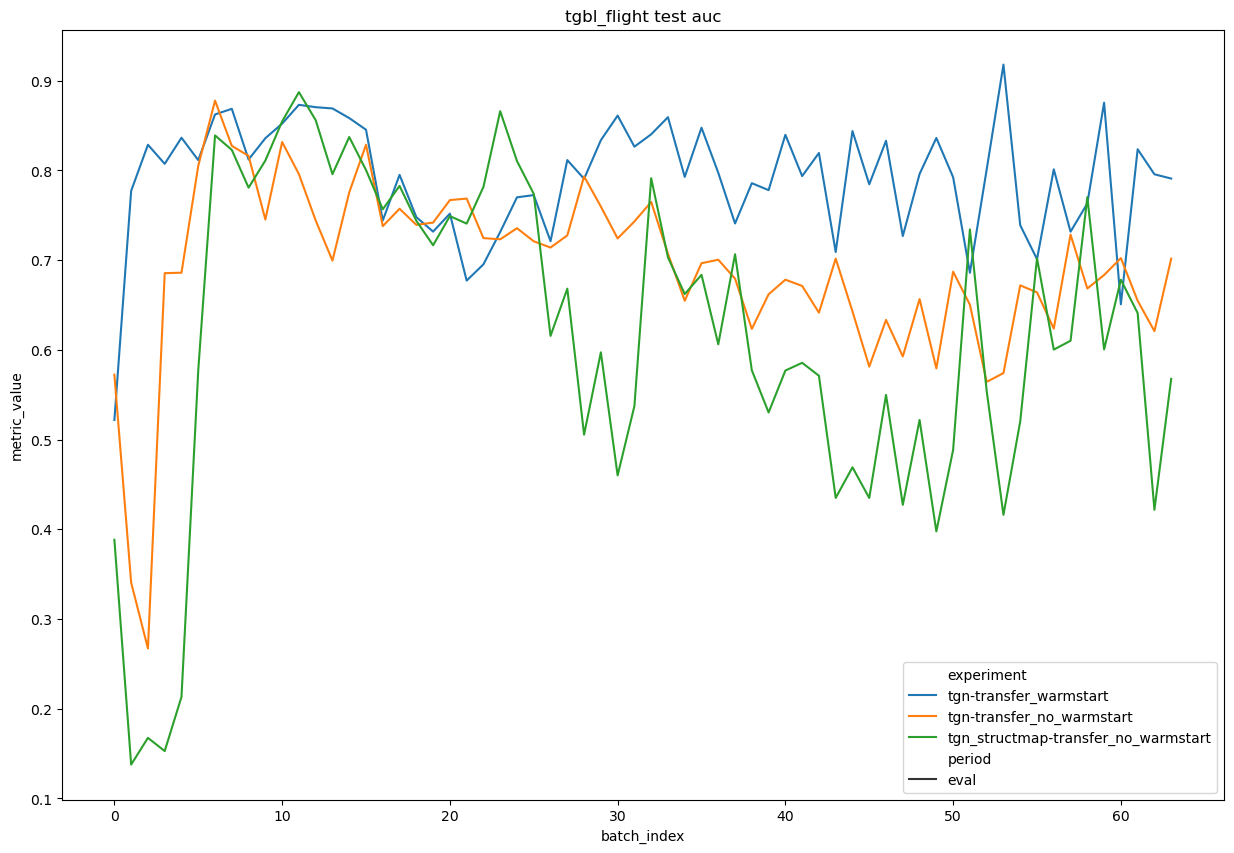

In [12]:
plot_df = plot_eval_metric_curves(dataset='tgbl_flight', metric_name='auc', batches_plot=100, val=False)